In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import random as rn
from scipy import interpolate
import math as m
import seaborn as sns
from matplotlib.colors import ListedColormap

In [14]:
#Достаем данные из файла
rawdata = []
file_obj = open('wine.data')
for line in file_obj:
    rawdata.append([float(char) for char in line.strip().split(',')])

#Создаем матрицу из массивов признаков и столбец-результат
rawdata = np.array(rawdata)
target = rawdata[:, 0]
data = np.delete(rawdata, 0, 1)

#Нормируем значения признаков
for i in range(len(data[0, :])):
    max_char = max(data[:, i])
    min_char = min(data[:, i])
    for j in range(len(data[:, 0])):
        data[j, i] = round((data[j, i] - min_char)/(max_char - min_char), 2)

#Делим данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(
data, target, test_size = 0.33, random_state=0)

wine_dataframe = pd.DataFrame({'Type':y_train, 'Alcohol':X_train[:, 0], 'Malic acid':X_train[:, 1], 
'Ash':X_train[:, 2],'Aclalinity of ash':X_train[:, 3], 'Magnesium':X_train[:, 4],
'Total phenols':X_train[:, 5], 'Flavanoids':X_train[:, 6], 'Nonflavanoid phenols':X_train[:, 7], 
'Proanthocyanins':X_train[:, 8], 'Color intensity':X_train[:, 9], 'Hue':X_train[:, 10],
'OD280/OD315 of diluted wines':X_train[:, 11], 'Proline':X_train[:, 12]})

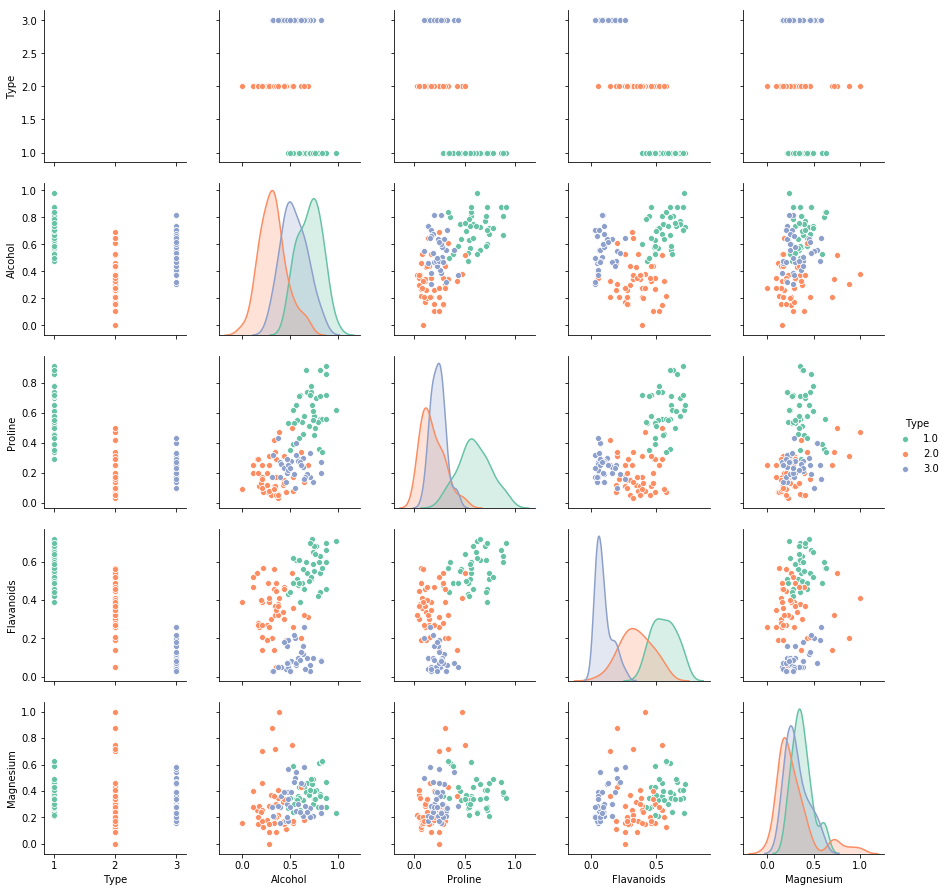

In [15]:
#Создаем матрицу рассеяния из dataframe, цвет точек задаем с помощью y_train
sns_plot = sns.pairplot(wine_dataframe[['Type', 'Alcohol', 'Proline', 'Flavanoids', 'Magnesium']], 
                        hue='Type', palette="Set2", diag_kind="kde")

plt.show()

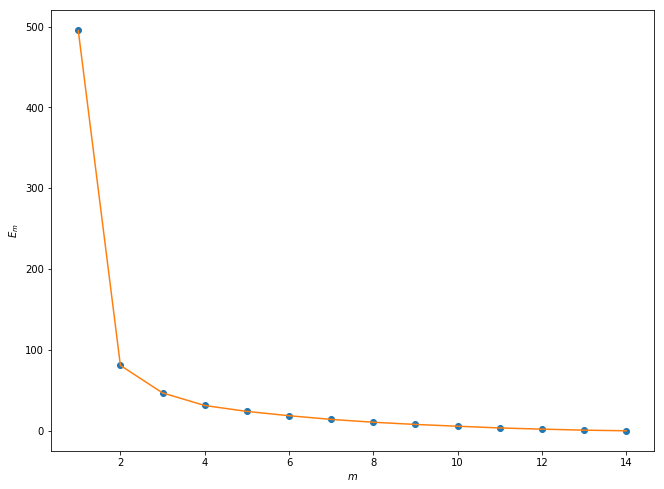

In [16]:
#Применим ли метод главных компонент?
A = np.dot(np.transpose(data), data)
eigenvalues, eigenvectors = np.linalg.eig(A)
C = np.sort(eigenvalues)
B = [np.sum(C)]
for i in range(len(eigenvalues)):
    C = np.delete(C, len(C) - 1)
    B.append(np.sum(C))
plt.plot(range(1, len(B) + 1), B, 'o')
plt.plot(range(1, len(B) + 1), B, '-')
plt.xlabel('$m$')
plt.ylabel('$E_m$')
plt.rcParams["figure.figsize"] = [10.8, 8.1]
plt.show()

absolute best result:
error = 0.0449, chebyshev, 1 neighbors


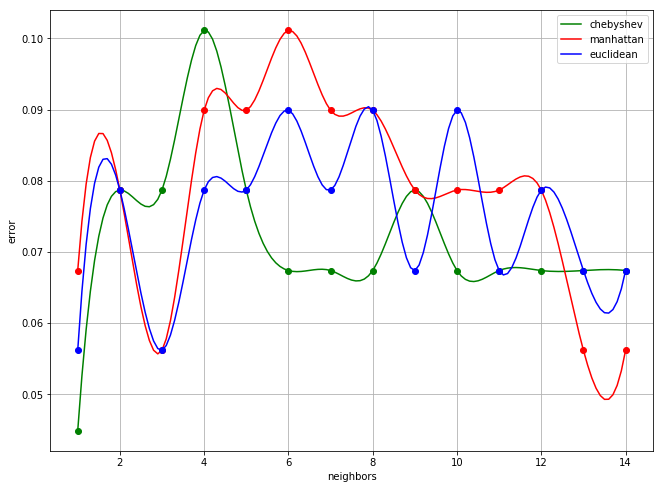

chebyshev best result:
error = 0.0449 1 neighbors

manhattan best result:
error = 0.0562 3 neighbors

euclidean best result:
error = 0.0562 1 neighbors



In [17]:
from sklearn.neighbors import KNeighborsClassifier
max_neighbors = 15
#Применяем PCA
pca = PCA(n_components=2)
pca.fit(data)
    
#Изменяем наши наборы данных под выбранные признаки
data = pca.transform(data)

X_train, X_test, y_train, y_test = train_test_split(
data, target, test_size = 0.5, random_state=0)
    
minkowski_p2 = []
for neighbors in range(1, max_neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    minkowski_p2.append(round(np.mean(y_pred != y_test), 4))

chebyshev = []
for neighbors in range(1, max_neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbors, metric = 'chebyshev')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    chebyshev.append(round(np.mean(y_pred != y_test), 4))

manhattan = []
for neighbors in range(1, max_neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbors, metric = 'manhattan')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    manhattan.append(round(np.mean(y_pred != y_test), 4))
    
#Создаем массив точек, по которому будем определять метрику и количество соседей, где ошибка минимальна 
points = [list(a) for a in zip(3*range(1, max_neighbors), chebyshev + manhattan + minkowski_p2)]
errors = []
    
for i in range(len(points)):
    errors.append(points[i][1])
    
least_error = min(errors)
least_errorC = min(chebyshev)
least_errorM = min(manhattan)
least_errorQ = min(minkowski_p2)

neig = max_neighbors
for point in points:
    if point[1] == least_error:
        if point[0] < neig:
            best = point
            neig = point[0]
        else:
            neig = point[0]
            
neigC = max_neighbors
for point in zip(range(1, max_neighbors), chebyshev):
    if point[1] == least_errorC:
        if point[0] < neigC:
            bestC = point
            neigC = point[0]
        else:
            neigC = point[0]

neigM = max_neighbors
for point in zip(range(1, max_neighbors), manhattan):
    if point[1] == least_errorM:
        if point[0] < neigM:
            bestM = point
            neigM = point[0]
        else:
            neigM = point[0]

neigQ = max_neighbors
for point in zip(range(1, max_neighbors), minkowski_p2):
    if point[1] == least_errorQ:
        if point[0] < neigQ:
            bestQ = point
            neigQ = point[0]
        else:
            neigQ = point[0]
            
#Печатаем результат
print('absolute best result:\n' + 'error = ' + str(best[1]) + 
', chebyshev, '*(points.index(best) < len(chebyshev)) + ', manhattan, '*(len(chebyshev) <= 
points.index(best) < len(chebyshev) + len(manhattan)) + ', euclidean, '*(len(chebyshev) + len(manhattan) <= 
points.index(best)) + str(best[0]) + ' neighbors')

best_metric = 'manhattan'*(len(chebyshev) <= 
points.index(best) < len(chebyshev) + len(manhattan)) + 'euclidean'*(len(chebyshev) + len(manhattan) <= 
points.index(best)) + 'chebyshev'*(points.index(best) < len(chebyshev))

#Строим график
x = np.arange(1, len(chebyshev) + 1)
    
f_c = interpolate.interp1d(x, chebyshev, kind='cubic')
f_m = interpolate.interp1d(x, manhattan, kind='cubic')
f_mk = interpolate.interp1d(x, minkowski_p2, kind='cubic')
    
xnew = np.arange(1, len(chebyshev) + 0.1, 0.1)
xnew[len(xnew)-1] = m.floor(xnew[len(xnew)-1])
      
plt.rcParams["figure.figsize"] = [10.8, 8.1]
        
plt.plot(x, chebyshev, 'go')
plt.plot(xnew, f_c(xnew), color='g', linestyle='solid', label = 'chebyshev')
plt.plot(x, manhattan, 'ro')
plt.plot(xnew, f_m(xnew), color='r', linestyle='solid', label = 'manhattan')
plt.plot(x, minkowski_p2, 'bo')
plt.plot(xnew, f_mk(xnew), color='b', linestyle='solid', label = 'euclidean')

plt.grid(True)
plt.xlabel('neighbors')
plt.ylabel('error')
    
#Легенда для всего рисунка
plt.legend()

plt.show()

print('chebyshev best result:\n' + 'error = ' + str(bestC[1]) + ' ' + str(bestC[0]) + ' neighbors\n')
print('manhattan best result:\n' + 'error = ' + str(bestM[1]) + ' ' + str(bestM[0]) + ' neighbors\n')
print('euclidean best result:\n' + 'error = ' + str(bestQ[1]) + ' ' + str(bestQ[0]) + ' neighbors\n')

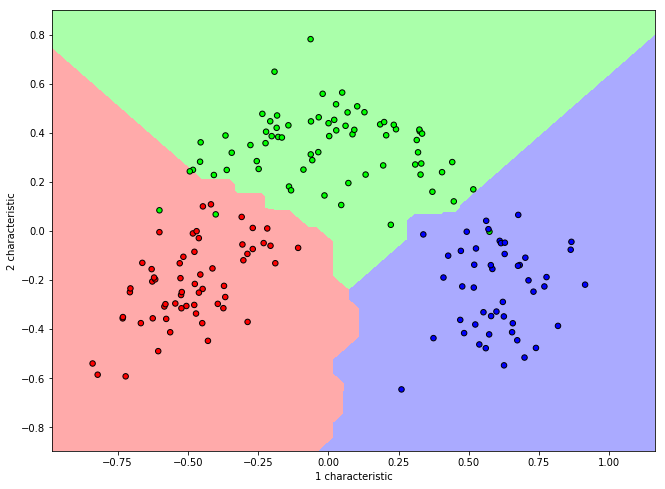

In [18]:
delta = 0.001
X_min, X_max = X_test[:, 0].min() - 0.25, X_test[:, 0].max() + 0.25
Y_min, Y_max = X_test[:, 1].min() - 0.25, X_test[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(X_min, X_max, delta),
                     np.arange(Y_min, Y_max, delta))

cmap_points = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cmap_space = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

knn = KNeighborsClassifier(n_neighbors=best[0], metric=best_metric).fit(X_train, y_train)
    
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_space)
plt.xlabel('1 characteristic')
plt.ylabel('2 characteristic')

# Plot also the training points
plt.scatter(data[:, 0], data[:, 1], c=target, marker='o', cmap=cmap_points,
            edgecolor='k', s=30)
errors = []

for i in range(len(y_test)):
    if (knn.predict(np.reshape(X_test[i, :], (1, 2))) != y_test[i]):
        errors.append(X_test[i, :])
        
errors = np.array(errors)

#plt.scatter(errors[:, 0], errors[:, 1], c=np.array([4,4,4,4]), marker='X', cmap=ListedColormap(['#000000']),
         #  edgecolor='k', s=60)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plot = plt.show()